# Using split tools in `datasets`

In [1]:
%load_ext autoreload
%autoreload 2
# import sys
# sys.path.append('../')

from PyBMF.datasets import NoSplit, RatioSplit, CrossValidation

c:\Users\nieht\Anaconda3\envs\pybmf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PyBMF.datasets import MovieLensData

data = MovieLensData(size='100k')
data.load()

data.X

d:\Dropbox\PyBMF\examples\settings.ini


<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 100000 stored elements in Compressed Sparse Row format>

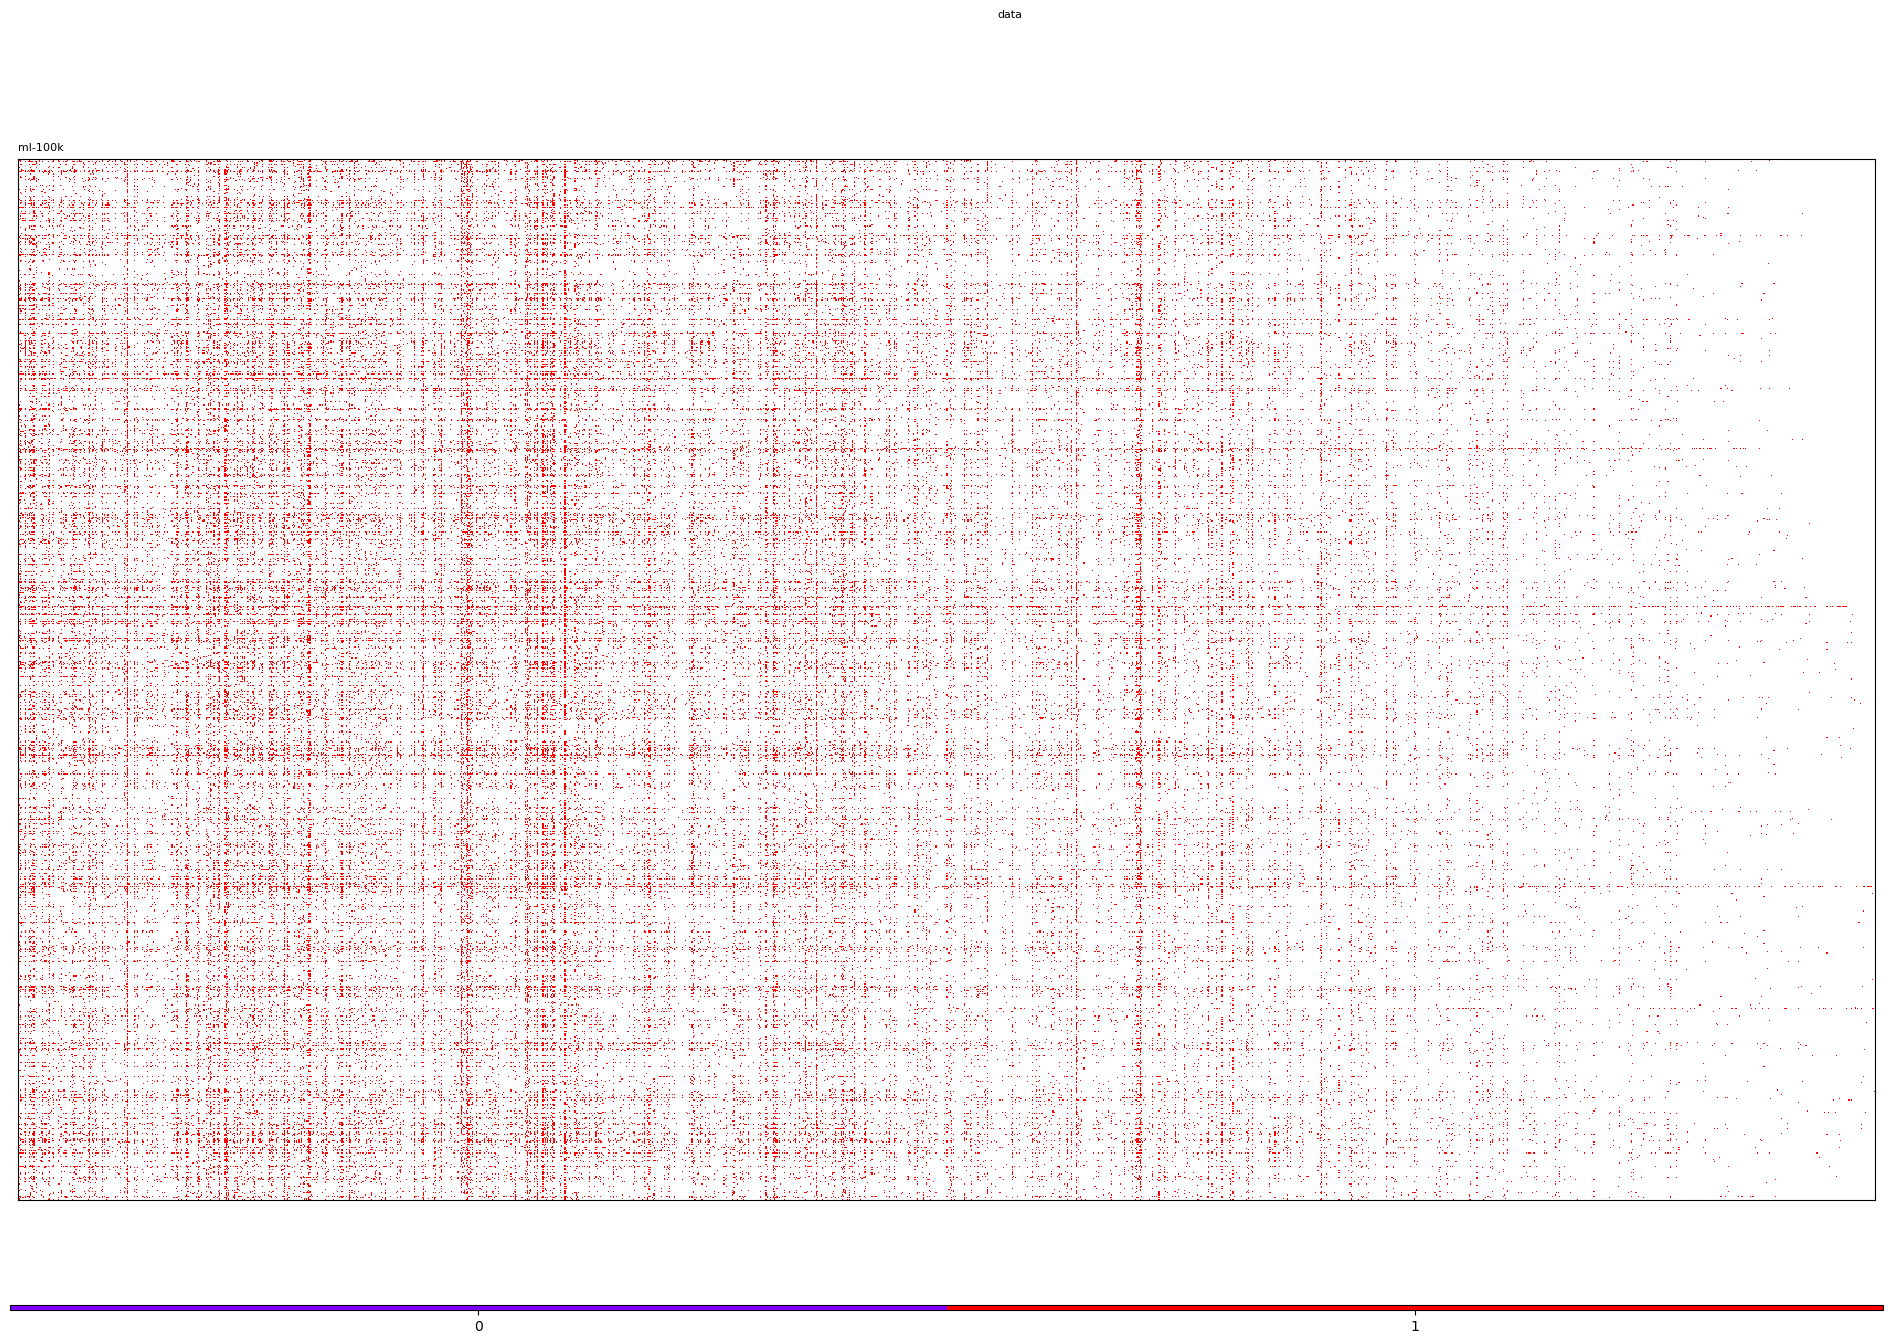

<Figure size 640x480 with 0 Axes>

In [3]:
from PyBMF.utils import show_matrix

show_matrix([(data.X, [0, 0], 'ml-100k')], colorbar=True, discrete=True, clim=[0, 1], title='data')

# 1. No split

This will point `X_train`, `X_val` and `X_test` to the same matrix.

In [4]:
split = NoSplit(X=data.X)
split.__dict__

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1721790690
[I]   train_size   : 100000
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1721790690


{'X': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_val': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'rs': <PyBMF.datasets.RatioSplit.RatioSplit at 0x28383b2aa30>,
 'pos_size': 100000}

# 2. Ratio split
## a. Sampling positives

In [5]:
ratiosplit = RatioSplit(X=data.X, test_size=0.2, val_size=0.1, seed=1000)

[I] RatioSplit, sampling positives
[I]   seed         : 1000
[I]   train_size   : 70000
[I]   val_size     : 10000
[I]   test_size    : 20000
[I]   seed         : 1000


In [6]:
ratiosplit.__dict__

{'X': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_train': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 70000 stored elements in Compressed Sparse Row format>,
 'X_val': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 10000 stored elements in Compressed Sparse Row format>,
 'X_test': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 20000 stored elements in Compressed Sparse Row format>,
 'seed': 1000,
 'rng': RandomState(MT19937) at 0x20602E4EE40,
 'pos_train_size': 70000,
 'pos_val_size': 10000,
 'pos_test_size': 20000}

## b. Sampling nagetives

In [7]:
ratiosplit.negative_sample(train_size=ratiosplit.pos_train_size, val_size=ratiosplit.pos_val_size, test_size=ratiosplit.pos_test_size, type='popularity')

[I] RatioSplit, sampling negatives
[I]   all_negatives: 1486126
[I]   n_negatives  : 100000
[I]   train_size   : 70000
[I]   val_size     : 10000
[I]   test_size    : 20000
[I]   seed         : 1000


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
ratiosplit.__dict__

{'X': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_train': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 140000 stored elements in Compressed Sparse Row format>,
 'X_val': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 20000 stored elements in Compressed Sparse Row format>,
 'X_test': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 40000 stored elements in Compressed Sparse Row format>,
 'seed': 1000,
 'rng': RandomState(MT19937) at 0x20602E4EE40,
 'pos_train_size': 70000,
 'pos_val_size': 10000,
 'pos_test_size': 20000,
 'neg_train_size': 70000,
 'neg_val_size': 10000,
 'neg_test_size': 20000}

Check if zeros are added to `csr_matrix` using `nnz` and `sum()`.

`nnz` are for computing non-zeros in `scipy.sparse`. Since we manually added zeros in `negative_sample()`, this measure will return the number of positive and negative samples.

In [9]:
print(ratiosplit.X_train.nnz, ratiosplit.X_train.sum(), ratiosplit.pos_train_size)
print(ratiosplit.X_val.nnz,   ratiosplit.X_val.sum(),   ratiosplit.pos_val_size)
print(ratiosplit.X_test.nnz,  ratiosplit.X_test.sum(),  ratiosplit.pos_test_size)

140000 70000 70000
20000 10000 10000
40000 20000 20000


Check if zeros are added to `csr_matrix` by turning it into `coo_matrix` or triplet.

In [10]:
from PyBMF.utils import to_triplet

_, _, values = to_triplet(ratiosplit.X_val)
print(len(values), sum(values))

20000 10000.0


# 3. Cross validation

## a Sampling positives

First set up fold config, then call `get_fold()` starting from fold(0).

In [11]:
cv = CrossValidation(X=data.X, test_size=0.2, n_folds=5)

[I] CrossValidation, sampling positives
[I]   seed         : 1709302921
[I]   n_folds      : 5
[I]   partition    : [0, 16000, 32000, 48000, 64000, 80000]
[I]   train + val  : 80000
[I]   test_size    : 20000


In [12]:
cv.__dict__

{'X': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_train': None,
 'X_val': None,
 'X_test': None,
 'seed': 1709302921,
 'rng': RandomState(MT19937) at 0x20602E4ED40,
 'cv_pos_partition': [0, 16000, 32000, 48000, 64000, 80000],
 'cv_pos_data_idx': array([36209, 72549, 59878, ..., 50795, 50347, 75208]),
 'n_folds': 5,
 'pos_train_val_size': 80000,
 'pos_test_size': 20000,
 'ns_initialized': False}

In [13]:
cv.get_fold(0)

[I] CrossValidation, current fold : 0
[I] CrossValidation, get indices for current fold
[E]   current_fold should lie in [1, n_fold]
[I]   fold size            : (64000, 16000, 20000)
[W]   No negative sampling config.


## b. Sampling negatives

Use this if you want to sample negatives for each fold.

It will try to sample the same amount of negatives in positive partitions.

Note that usually sampling negatives in training set does not make sense in `prediction` tasks.

In [14]:
cv.negative_sample(test_size=cv.pos_test_size, train_val_size=cv.pos_train_val_size, type='popularity')

[I] CrossValidation, sampling negatives
[I]   n_folds      : 5
[I]   partition    : [0, 16000, 32000, 48000, 64000, 80000]
[I]   train + val  : 80000
[I]   test_size    : 20000


In [15]:
cv.__dict__

{'X': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 'X_train': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 64000 stored elements in Compressed Sparse Row format>,
 'X_val': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 16000 stored elements in Compressed Sparse Row format>,
 'X_test': <943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 20000 stored elements in Compressed Sparse Row format>,
 'seed': 1709302921,
 'rng': RandomState(MT19937) at 0x20602E4ED40,
 'cv_pos_partition': [0, 16000, 32000, 48000, 64000, 80000],
 'cv_pos_data_idx': array([36209, 72549, 59878, ..., 50795, 50347, 75208]),
 'n_folds': 5,
 'pos_train_val_size': 80000,
 'pos_test_size': 20000,
 'ns_initialized': True,
 'pos_train_size': 64000,
 'pos_val_size': 16000,
 'cv_neg_partition': [0, 16000, 32000, 48000, 64000, 80000],
 'U_neg': array([367, 226, 287, ..., 462, 784,  91]),
 'V_neg': array([ 507,

In [16]:
cv.get_fold(0)

[I] CrossValidation, current fold : 0
[I] CrossValidation, get indices for current fold
[E]   current_fold should lie in [1, n_fold]
[I]   fold size            : (64000, 16000, 20000)
[I] CrossValidation, get indices for current fold
[E]   current_fold should lie in [1, n_fold]
[I]   fold neg sample size : (64000, 16000, 20000)
